# TICA

TICA <cite data-cite="molgedey1994separation">(Molgedey, 1994)</cite> is short for Time-lagged Independent Component Analysis and is a linear transformation method that can be used for dimensionality reduction. It was introduced for molecular dynamics in <cite data-cite="perez2013identification">(Pérez-Hernández, 2013)</cite> and as a method in the pipeline of Markov model construction in <cite data-cite="perez2013identification">(Pérez-Hernández, 2013)</cite> and <cite data-cite="schwantes2013improvements">(Schwantes, 2013)</cite>. 

To that end, it maps the data to the "slow" processes, i.e., it finds the coordinates of maximal autocorrelation at a given lag time $\tau$:


In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection
import numpy as np
import sktime
from sklearn.decomposition import PCA

In [2]:
rnd = np.random.RandomState(seed=17)  # use a random state with a fixed seed for reproducibility

To demonstrate TICA compared to Principle Component Analysis (PCA), we consider the following example setup:

- We generate a synthetic trajectory of observations of states $S = \{0, 1\}$ which is generated from a Markov state model (see [here](../index_msm.rst) for documentation on Markov state models). The only important thing for now is that it contains conditional probability to go from one state to another, i.e., given a transition matrix
    $$
    P = \begin{pmatrix} 0.97 & 0.03 \\ 0.03 & 0.97 \end{pmatrix}
    $$
  we have a probability $P_{11} = 97\%$ to stay in state "0" and a $P_{12} = 3\%$ to transition from state "0" to state "1" and vice versa. 

In [3]:
# creation of a Markov state model instance given a transition matrix
msm = sktime.markov.msm.MarkovStateModel(
    transition_matrix=[[0.97, 0.03], [0.03, 0.97]]
)

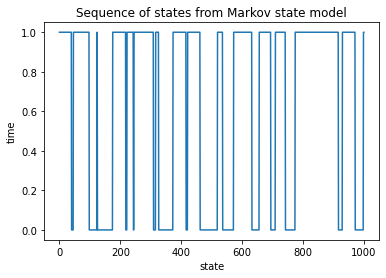

In [4]:
# we simulate a discrete trajectory (dtraj) containing 1000 given the Markov state model
dtraj = msm.simulate(n_steps=1000, seed=13)
# .. and visualize the observed state transitions
plt.plot(dtraj)
plt.xlabel('state')
plt.ylabel('time')
plt.title('Sequence of states from Markov state model');

Now given this sequence of states we can observe that it stays in one state for most of the time, transitions to the other state and again, stays there for a longer period of time. To demonstrate the potential advantage of TICA over PCA we map the state sequence into $\mathbb{R}^2$ by using two multivariate normal distributions with the same covariance matrix but shifted means:

In [5]:
ftraj = np.empty((len(dtraj), 2))  # allocate space for the 2-dimensional trajectory

state_0_indices = np.where(dtraj == 0)[0]  # indices where dtraj is 0
state_1_indices = np.where(dtraj == 1)[0]  # indices where dtraj is 1

cov =  [[5.7, 5.65], [5.65, 5.7]]  # the covariance matrix

# fill allocated space with samples
ftraj[state_0_indices] = rnd.multivariate_normal(mean=[0.0, 0.0], cov=cov, size=len(state_0_indices))
ftraj[state_1_indices] = rnd.multivariate_normal(mean=[0.0, 5.0], cov=cov, size=len(state_1_indices))

Visualizing the mapped trajectory shows two parallel and elongated ellipsoid-shaped distributions. Temporally, a relatively long time is spent in either of these distributions before jumping to the other.

This can be observed in the right-hand plot: The data is supersampled (each consecutive point-pair in the time series is linearly interpolated with 50 interpolation points) so that transition jumps become visible; these transitions are significantly lower intensity than the ellipsoids. If jumps were frequent, the in-between region would be much brighter.

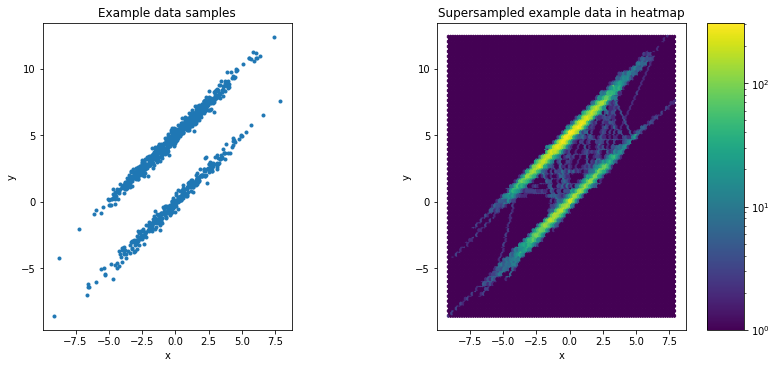

In [6]:
f, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
ax1, ax2 = axes.flat

# scatter plot of samples
ax1.scatter(*(ftraj.T), marker='.')
ax1.set_aspect('equal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Example data samples')

# interpolate ftraj so that 50 times more steps are made and transitions become visible
# in heatmap representation
n_interp = 50
ftraj_interp = np.empty((len(dtraj)*n_interp, 2))
ftraj_interp[:, 0] = np.interp(np.arange(len(dtraj), step=1./n_interp), np.arange(len(dtraj)), ftraj[:, 0])
ftraj_interp[:, 1] = np.interp(np.arange(len(dtraj), step=1./n_interp), np.arange(len(dtraj)), ftraj[:, 1])

# heatmap
hb = ax2.hexbin(ftraj_interp[:, 0], ftraj_interp[:, 1], bins='log')
ax2.set_aspect('equal')
f.colorbar(hb, ax=axes.flat)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Supersampled example data in heatmap');

If we project back into one dimension with PCA, the result contains basically no signal: PCA finds the axis that maximizes variance, which is along long axis of the ellipsoids and completely ignores temporal information.

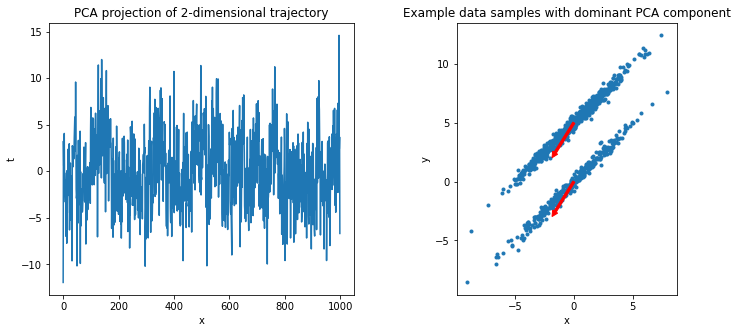

In [7]:
pca = PCA(n_components=1).fit(ftraj)  # fit the 2-dimensional data

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(pca.transform(ftraj))
ax1.set_title('PCA projection of 2-dimensional trajectory')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

dxy = pca.components_[0]  # dominant pca component
dxy *= 3./np.linalg.norm(dxy)  # so that vector has length 3

ax2.scatter(*(ftraj.T), marker='.')
ax2.arrow(0, 0, dxy[0], dxy[1], head_width=0.5, head_length=0.5, width=0.2, color='r')
ax2.arrow(0, 5, dxy[0], dxy[1], head_width=0.5, head_length=0.5, width=0.2, color='r')
ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Example data samples with dominant PCA component');

On the other hand, projecting with TICA takes temporal information into account and finds the dominant slow direction, i.e., the rare transition between the two distributions.

We create a TICA estimator, parameterized by the `lagtime`, which is the time shift for which autocorrelations are taken into account, and `dim`, which is the dimension. Here, the dimension can either be an `int` , a `float`, or `None` - each having significant influence on how the projection dimension is determined:

- in case `dim` is `None`, all available ranks are kept;
- in case `dim` is an integer (like in this case), it must be positive and fixes the projection dimension to the given value;
- in case `dim` is a floating point value (e.g., `TICA(..., dim=0.7)`), it must be `0 < dim <= 1`. Then, it selects the number of dimensions such that the amount of kinetic variance that needs to be explained is greater than the percentage specified by dim.

In [8]:
estimator = sktime.decomposition.TICA(
    lagtime=1,  # time shift is one step
    dim=1  # fix projection dimension explicitly
)
tica_model = estimator.fit(ftraj).fetch_model()  # fit and fetch model

Now we can repeat the experiment of above and plot the projected data as well as the dominant slow direction, maximizing autocorrelation (instead of variance, cf PCA).

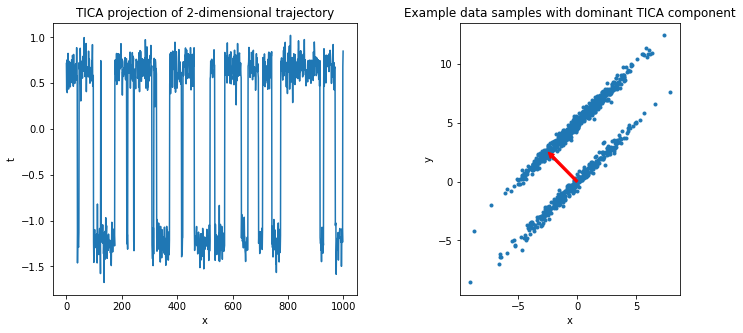

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(tica_model.transform(ftraj))
ax1.set_title('TICA projection of 2-dimensional trajectory')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

dxy = tica_model.eigenvectors[:, 0]  # dominant tica component
dxy *= 3./np.linalg.norm(dxy)  # so that vector has length 3

ax2.scatter(*(ftraj.T), marker='.')
ax2.arrow(0, 0, dxy[0], dxy[1], head_width=0.5, head_length=0.5, width=0.2, color='r')
ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Example data samples with dominant TICA component');